In [10]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem
import seaborn as sns
import pickle
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import pandas as pd


sns.set_theme(style='white',font_scale=1.5)

In [2]:
def shuffle_spikes(X, min_shift=100):
    X_shuff = np.zeros(X.shape)
    for i in range(X.shape[-1]):
        X_shuff[:,i] = np.roll(X[:,i], np.random.choice(
            np.arange(min_shift, X.shape[0])))
    return X_shuff

def binarize(traces):
    stds = np.std(traces,axis=-1)
    means = np.mean(traces,axis=-1)
    out = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            if traces[i,j]-means[i]>stds[i]:
                out[i][j] = 1
            else:
                out[i][j] = 0

    return out

# Stimulus specific component
Decoding the six stimuli all together, without non stimulus periods

<Figure size 1440x360 with 0 Axes>

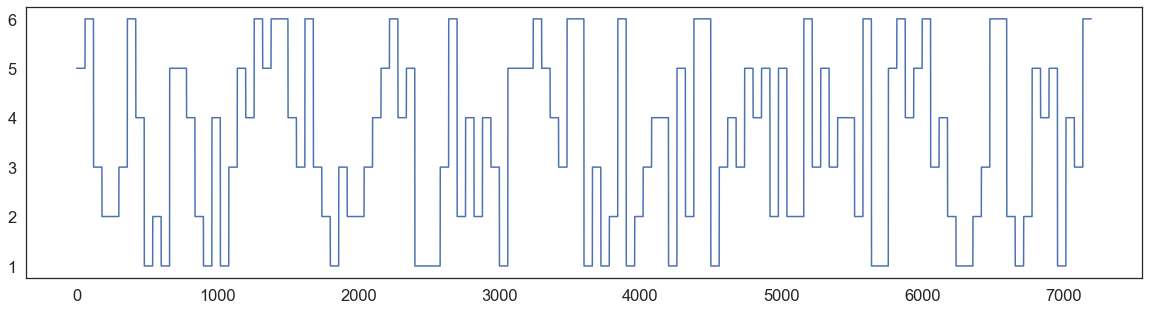

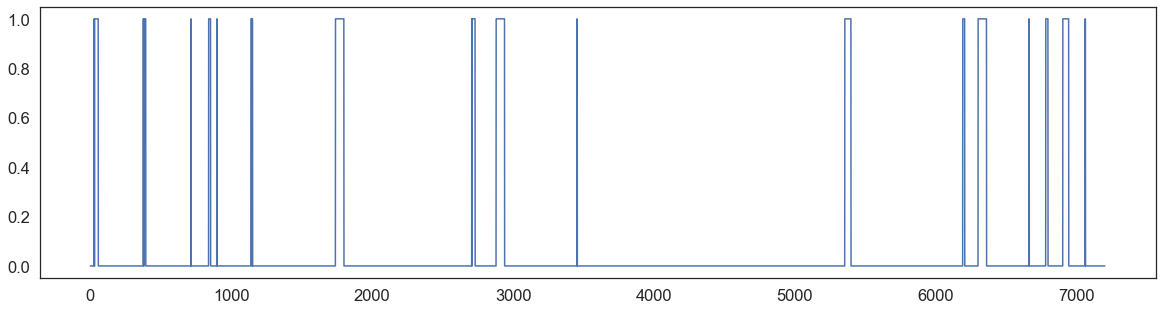

In [46]:
stimulus_only = True # use only stimulus periods
binarize_traces = True

data = np.load('../../../../data/raw_data/nike_calcium_trace.npy')
if binarize_traces:
    data = binarize(data)

X_all = data.T
with open('../../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)

stimulus_duration = 60 # in indexes
stimuli = [1,2,3,4,5,6]



plt.figure(figsize=(20,5))
y_all = np.zeros(X_all.shape[0])
for s in stimuli:
    stim_mask = np.zeros(X_all.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1
        y_all[onset:onset+stimulus_duration] = s
    
# isolate stimuli periods   
if stimulus_only: 
    X = X_all[y_all>0]
    y = y_all[y_all>0]
else:
    X = X_all
    y = y_all

plt.figure(figsize=(20,5))
plt.plot(y)
plt.figure(figsize=(20,5))
plt.plot(X[:,0])



In [47]:
from itertools import product
n_splits = 10

n_periods = 4
len_period = X.shape[0]//4


Xt = [X[t*len_period:(t+1)*len_period] for t in range(n_periods)]
yt = [y[t*len_period:(t+1)*len_period] for t in range(n_periods)]


classifier = linear_model.LogisticRegression(solver="newton-cg", tol=1,C=1000)
scaler = StandardScaler()

classifier = Pipeline(steps=[("scaler",scaler), ("logistic", logistic)])

performance_data = {'train_period':[],'test_period':[],
                    'fold':[],'f1_score':[]}

for t1,t2 in product(range(n_periods),range(n_periods)):
    print(f'Training on {t1+1}, testion on {t2+1} ...')

    kf1 = StratifiedKFold(n_splits=n_splits,shuffle=True)
    kf2 = StratifiedKFold(n_splits=n_splits,shuffle=True)

    splits = zip(kf1.split(Xt[t1],yt[t1]),kf2.split(Xt[t2],yt[t2]))

    for i,((train_index,_), (_,test_index)) in enumerate(splits):

        X_train, X_test = Xt[t1][train_index], Xt[t2][test_index]
        y_train, y_test = yt[t1][train_index], yt[t2][test_index]
        # LR classifier
        split_classifier = clone(classifier)
        split_classifier.fit(X_train, y_train)

        y_pred = split_classifier.predict(X_test)
        performance = f1_score(y_test,y_pred,average='weighted')

        performance_data['train_period'].append(t1+1)
        performance_data['test_period'].append(t2+1)
        performance_data['fold'].append(i)
        performance_data['f1_score'].append(performance)

performance_data = pd.DataFrame.from_dict(performance_data)


Training on 1, testion on 1 ...
Training on 1, testion on 2 ...
Training on 1, testion on 3 ...
Training on 1, testion on 4 ...
Training on 2, testion on 1 ...
Training on 2, testion on 2 ...
Training on 2, testion on 3 ...
Training on 2, testion on 4 ...
Training on 3, testion on 1 ...
Training on 3, testion on 2 ...
Training on 3, testion on 3 ...
Training on 3, testion on 4 ...
Training on 4, testion on 1 ...
Training on 4, testion on 2 ...
Training on 4, testion on 3 ...
Training on 4, testion on 4 ...


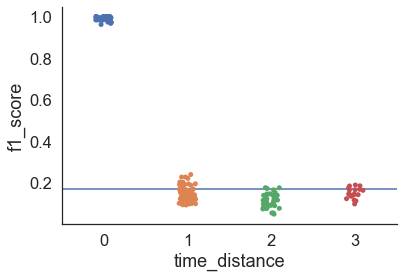

In [48]:
performance_data['time_distance'] = abs(performance_data['train_period']-performance_data['test_period'])
sns.stripplot(data=performance_data,x='time_distance',y='f1_score')
plt.axhline(y=1/6)
sns.despine()

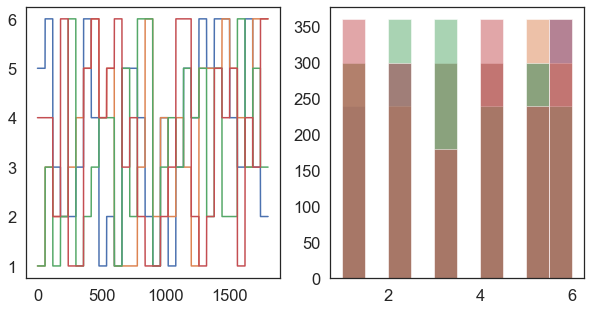

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in yt:
    plt.plot(i)
plt.subplot(1,2,2)
for i in yt:
    plt.hist(i,alpha=0.5)

# single stimulus

<Figure size 1440x360 with 0 Axes>

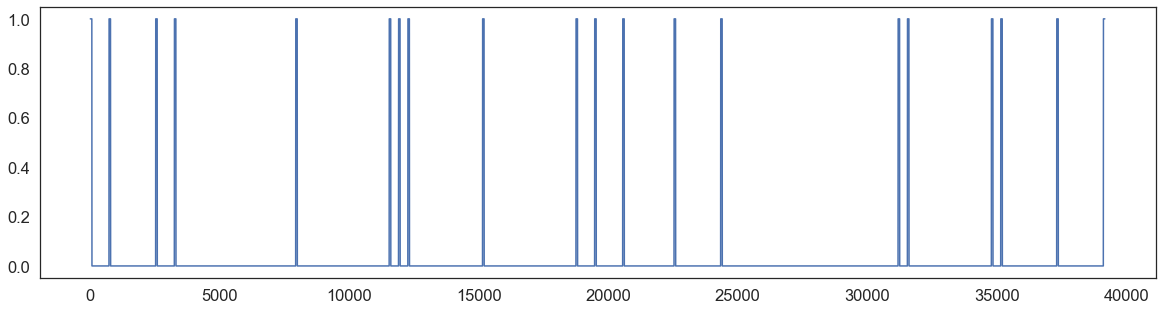

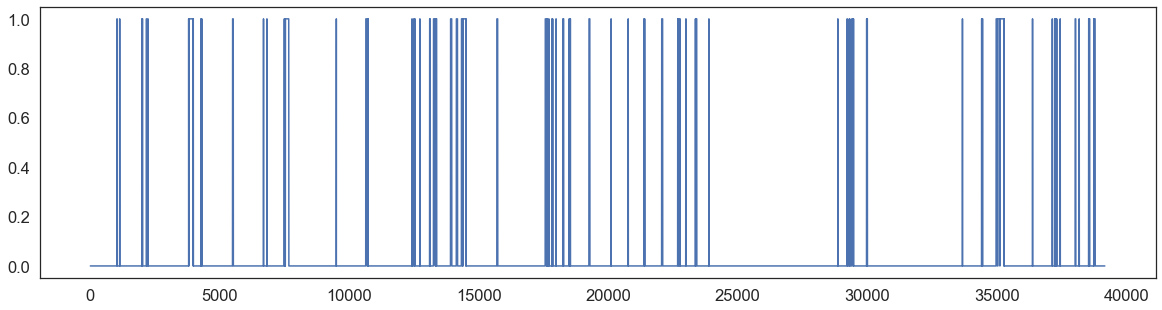

In [42]:
stimulus_only = False # use only stimulus periods
binarize_traces = True

data = np.load('../../../../data/raw_data/nike_calcium_trace.npy')
if binarize_traces:
    data = binarize(data)

X_all = data.T
with open('../../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)

stimulus_duration = 60 # in indexes
stimuli = [1]



plt.figure(figsize=(20,5))
y_all = np.zeros(X_all.shape[0])
for s in stimuli:
    stim_mask = np.zeros(X_all.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1
        y_all[onset:onset+stimulus_duration] = 1
    
# isolate stimuli periods   
if stimulus_only: 
    X = X_all[y_all>0]
    y = y_all[y_all>0]
else:
    X = X_all[np.where(y_all==1)[0][0]:np.where(y_all==1)[0][-1]]
    y = y_all[np.where(y_all==1)[0][0]:np.where(y_all==1)[0][-1]]

plt.figure(figsize=(20,5))
plt.plot(y)
plt.figure(figsize=(20,5))
plt.plot(X[:,0])

In [43]:
from itertools import product
n_splits = 10

n_periods = 4
len_period = X.shape[0]//4


Xt = [X[t*len_period:(t+1)*len_period] for t in range(n_periods)]
yt = [y[t*len_period:(t+1)*len_period] for t in range(n_periods)]


classifier = linear_model.LogisticRegression(solver="newton-cg", tol=1,C=1000)
scaler = StandardScaler()

classifier = Pipeline(steps=[("scaler",scaler), ("logistic", logistic)])

performance_data = {'train_period':[],'test_period':[],
                    'fold':[],'f1_score':[]}

for t1,t2 in product(range(n_periods),range(n_periods)):
    print(f'Training on {t1+1}, testion on {t2+1} ...')

    kf1 = StratifiedKFold(n_splits=n_splits,shuffle=True)
    kf2 = StratifiedKFold(n_splits=n_splits,shuffle=True)

    splits = zip(kf1.split(Xt[t1],yt[t1]),kf2.split(Xt[t2],yt[t2]))

    for i,((train_index,_), (_,test_index)) in enumerate(splits):

        X_train, X_test = Xt[t1][train_index], Xt[t2][test_index]
        y_train, y_test = yt[t1][train_index], yt[t2][test_index]
        # LR classifier
        split_classifier = clone(classifier)
        split_classifier.fit(X_train, y_train)

        y_pred = split_classifier.predict(X_test)
        performance = f1_score(y_test,y_pred,average='weighted')

        performance_data['train_period'].append(t1+1)
        performance_data['test_period'].append(t2+1)
        performance_data['fold'].append(i)
        performance_data['f1_score'].append(performance)

performance_data = pd.DataFrame.from_dict(performance_data)

Training on 1, testion on 1 ...
Training on 1, testion on 2 ...
Training on 1, testion on 3 ...
Training on 1, testion on 4 ...
Training on 2, testion on 1 ...
Training on 2, testion on 2 ...
Training on 2, testion on 3 ...
Training on 2, testion on 4 ...
Training on 3, testion on 1 ...
Training on 3, testion on 2 ...
Training on 3, testion on 3 ...
Training on 3, testion on 4 ...
Training on 4, testion on 1 ...
Training on 4, testion on 2 ...
Training on 4, testion on 3 ...
Training on 4, testion on 4 ...


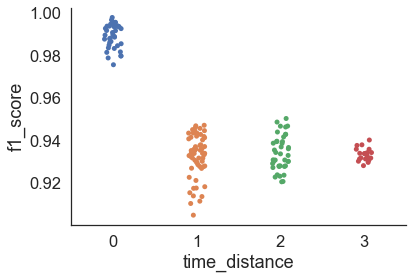

In [45]:
performance_data['time_distance'] = abs(performance_data['train_period']-performance_data['test_period'])
sns.stripplot(data=performance_data,x='time_distance',y='f1_score')
sns.despine()